In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
stm = pd.read_pickle('Stemmed.pkl')

In [3]:
# Label encode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
stm['label'] = le.fit_transform(stm['label'])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# Converting to DTM
cv = CountVectorizer(stop_words='english')

sdtm = cv.fit_transform(stm['processed_text'])

In [5]:
X = sdtm
y = stm['label']

In [6]:
# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

sel_k = 10000
selector = SelectKBest(chi2, k=sel_k)
X_new = selector.fit_transform(X, y)

In [7]:
# Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD

in_size = 1200 # DO NOT DO 5000 OR HIGHER
svd = TruncatedSVD(n_components=in_size)
X_new = svd.fit_transform(X_new)

In [38]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=101)

In [39]:
# Now do resampling
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=101)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

## Modeling

In [42]:
# Early Stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True
)


from keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

### Original ANN

In [43]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, input_dim=in_size, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    X_train_res, y_train_res,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    batch_size=32
)

Epoch 1/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6547 - loss: 0.6644 - val_accuracy: 0.7606 - val_loss: 0.5100 - learning_rate: 0.0010
Epoch 2/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.8028 - loss: 0.4523 - val_accuracy: 0.8037 - val_loss: 0.4653 - learning_rate: 0.0010
Epoch 3/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8541 - loss: 0.3487 - val_accuracy: 0.8144 - val_loss: 0.4470 - learning_rate: 0.0010
Epoch 4/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8803 - loss: 0.2880 - val_accuracy: 0.8198 - val_loss: 0.4466 - learning_rate: 0.0010
Epoch 5/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9014 - loss: 0.2562 - val_accuracy: 0.8178 - val_loss: 0.4772 - learning_rate: 0.0010
Epoch 6/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.9138 - loss: 0.2312 - val_accuracy: 0.8198 - val_loss: 0.4868 - learning_rate: 0.0010
Epoch 7/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9253 - loss

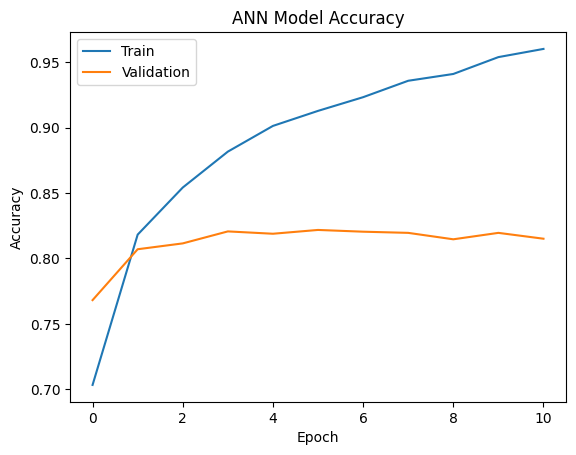

In [45]:
# Plot of epochs vs accuracy and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ANN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
# Model evaluation (sel_k = 10000, size = 1200, epochs=12 (with early stop))
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8154 - loss: 0.7663
Test Loss: 0.70854651927948, Test Accuracy: 0.8269617557525635


In [ ]:
from sklearn.metrics import accuracy_score

# Determining optimal threshold
thresholds = np.arange(0.0, 1.0, 0.01)
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_pred = (model.predict(X_test) > threshold).astype(int)
    f1 = accuracy_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

    # print(f"Threshold: {threshold}, Accuracy Score: {f1}")

print(f"Best Threshold: {best_threshold}, Best Accuracy Score: {best_f1}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━

In [ ]:
# Plot thresholds vs f1 score
thresholds = np.arange(0.0, 1.0, 0.01)
acc_scores = []

for threshold in thresholds:
    y_pred = (model.predict(X_test) > threshold).astype(int)
    a_score = accuracy_score(y_test, y_pred)
    acc_scores.append(a_score)

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━

Text(0, 0.5, 'Accuracy Score')

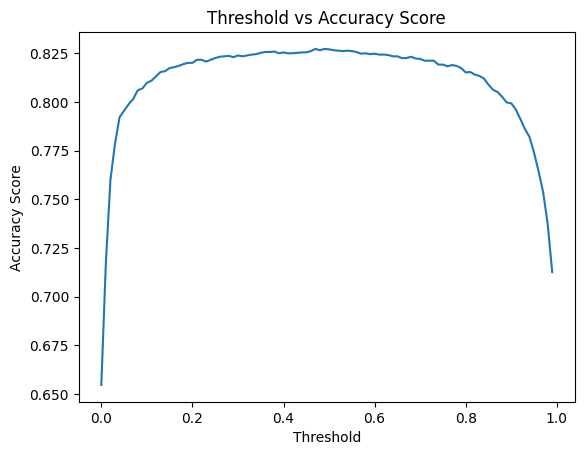

In [ ]:
plt.plot(thresholds, acc_scores)
plt.title('Threshold vs Accuracy Score')
plt.xlabel('Threshold')
plt.ylabel('Accuracy Score')

In [ ]:
# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (model.predict(X_test) > best_threshold).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.73      1545
           1       0.85      0.89      0.87      2928

    accuracy                           0.83      4473
   macro avg       0.81      0.80      0.80      4473
weighted avg       0.82      0.83      0.82      4473


Confusion Matrix:
[[1078  467]
 [ 311 2617]]


In [ ]:
print("Best Threshold: " + str(best_threshold))

Best Threshold: 0.48


### Deeper ANN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(8, input_dim=in_size, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(16, input_dim=in_size, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))


# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    X_train_res, y_train_res,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    batch_size=32
)

Epoch 1/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6822 - loss: 0.6169 - val_accuracy: 0.7518 - val_loss: 0.6076 - learning_rate: 0.0010
Epoch 2/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7909 - loss: 0.4846 - val_accuracy: 0.7657 - val_loss: 0.5589 - learning_rate: 0.0010
Epoch 3/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8105 - loss: 0.4470 - val_accuracy: 0.7771 - val_loss: 0.5367 - learning_rate: 0.0010
Epoch 4/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8279 - loss: 0.4147 - val_accuracy: 0.7306 - val_loss: 0.5940 - learning_rate: 0.0010
Epoch 5/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8407 - loss: 0.4017 - val_accuracy: 0.7579 - val_loss: 0.5771 - learning_rate: 0.0010
Epoch 6/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8499 - loss: 0.3835 - val_accuracy: 0.7597 - val_loss: 0.5543 - learning_rate: 0.0010
Epoch 7/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8522 - loss: 0.

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━

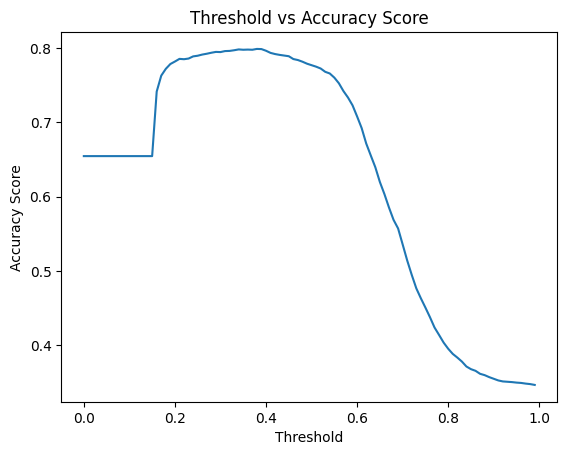

Best Threshold based on accuracy: 0.38


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' and 'X_test', 'y_test' are defined from the previous code

thresholds = np.arange(0.0, 1.0, 0.01)
acc_scores = []

for threshold in thresholds:
    y_pred = (model.predict(X_test) > threshold).astype(int)
    a_score = accuracy_score(y_test, y_pred)
    acc_scores.append(a_score)

plt.plot(thresholds, acc_scores)
plt.title('Threshold vs Accuracy Score')
plt.xlabel('Threshold')
plt.ylabel('Accuracy Score')
plt.show()

best_threshold = thresholds[np.argmax(acc_scores)]
print(f"Best Threshold based on accuracy: {best_threshold}")

In [ ]:
y_pred = (model.predict(X_test) > best_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1545
           1       0.83      0.86      0.85      2928

    accuracy                           0.80      4473
   macro avg       0.78      0.77      0.77      4473
weighted avg       0.80      0.80      0.80      4473


Confusion Matrix:
[[1045  500]
 [ 399 2529]]

Accuracy: 0.7990163201430807


### CNN

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, GlobalMaxPooling1D, Dense, Dropout, Add
from tensorflow.keras.models import Model

num_documents = X_train_res.shape[0]
num_features = X_train_res.shape[1]

X_train_cnn = X_train_res[..., np.newaxis]


# Reshape DTM for CNN (add channel dimension)
X_train_cnn = X_train_res[..., np.newaxis]  # Shape: (num_documents, num_features, 1)

# Input layer
inputs = Input(shape=(num_features, 1))

# Block 1
x = Conv1D(128, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = GlobalMaxPooling1D()(x)

# Block 2 (Residual connection)
residual = x  # Save the input for the residual connection
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Add()([x, residual])  # Add residual connection

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
# model.summary()


In [ ]:
# Train model
history = model.fit(
    X_train_cnn, y_train_res,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    batch_size=32
)

Epoch 1/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 327s 432ms/step - accuracy: 0.6475 - loss: 1.2577 - val_accuracy: 0.4679 - val_loss: 0.9222 - learning_rate: 0.0010
Epoch 2/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 259s 347ms/step - accuracy: 0.6799 - loss: 0.6484 - val_accuracy: 0.7096 - val_loss: 0.6232 - learning_rate: 0.0010
Epoch 3/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 262s 347ms/step - accuracy: 0.6923 - loss: 0.6166 - val_accuracy: 0.6886 - val_loss: 0.6414 - learning_rate: 0.0010
Epoch 4/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 254s 337ms/step - accuracy: 0.6942 - loss: 0.6053 - val_accuracy: 0.7364 - val_loss: 0.6558 - learning_rate: 0.0010
Epoch 5/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 260s 335ms/step - accuracy: 0.7001 - loss: 0.5913 - val_accuracy: 0.6910 - val_loss: 0.6151 - learning_rate: 0.0010


140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step
140/140 ━━━━

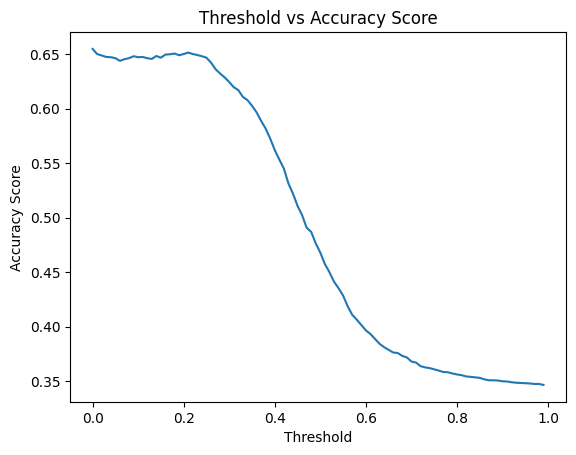

Best Threshold based on accuracy: 0.0


In [ ]:
# prompt: Plot thresholds vs accuracy and determine the best threshold based on accuracy

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming 'model' and 'X_test', 'y_test' are defined from the previous code

thresholds = np.arange(0.0, 1.0, 0.01)
acc_scores = []

for threshold in thresholds:
    y_pred = (model.predict(X_test) > threshold).astype(int)
    a_score = accuracy_score(y_test, y_pred)
    acc_scores.append(a_score)

plt.plot(thresholds, acc_scores)
plt.title('Threshold vs Accuracy Score')
plt.xlabel('Threshold')
plt.ylabel('Accuracy Score')
plt.show()

best_threshold = thresholds[np.argmax(acc_scores)]
print(f"Best Threshold based on accuracy: {best_threshold}")

In [ ]:
y_pred = (model.predict(X_test) > best_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1545
           1       0.65      1.00      0.79      2928

    accuracy                           0.65      4473
   macro avg       0.83      0.50      0.40      4473
weighted avg       0.77      0.65      0.52      4473


Confusion Matrix:
[[   1 1544]
 [   0 2928]]

Accuracy: 0.6548177956628661


### LSTM

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

# Reshape the input data for LSTM
X_train_lstm = X_train_res.reshape(X_train_res.shape[0], 1, X_train_res.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))) #input_shape = (timesteps, features)
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train_lstm, y_train_res,
    epochs=100,
    validation_data=(X_test_lstm, y_test),
    callbacks=[early_stopping, lr_scheduler],
    batch_size=32
)

Epoch 1/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7393 - loss: 0.5573 - val_accuracy: 0.7959 - val_loss: 0.4495 - learning_rate: 0.0010
Epoch 2/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8759 - loss: 0.3153 - val_accuracy: 0.8182 - val_loss: 0.4392 - learning_rate: 0.0010
Epoch 3/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9050 - loss: 0.2475 - val_accuracy: 0.8162 - val_loss: 0.4595 - learning_rate: 0.0010
Epoch 4/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9237 - loss: 0.2034 - val_accuracy: 0.8216 - val_loss: 0.4765 - learning_rate: 0.0010
Epoch 5/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9345 - loss: 0.1782 - val_accuracy: 0.8276 - val_loss: 0.4987 - learning_rate: 0.0010
Epoch 6/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9436 - loss: 0.1582 - val_accuracy: 0.8180 - val_loss: 0.5296 - learning_rate: 0.0010
Epoch 7/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9473 - lo

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

thresholds = np.arange(0.0, 1.0, 0.01)
acc_scores = []

for threshold in thresholds:
    y_pred = (model.predict(X_test_lstm) > threshold).astype(int)
    a_score = accuracy_score(y_test, y_pred)
    acc_scores.append(a_score)

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━

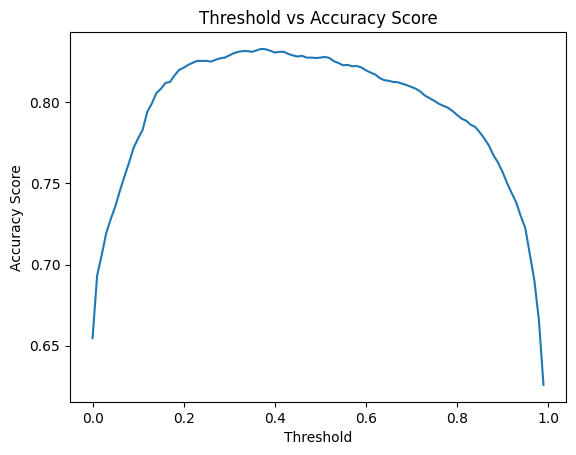

Best Threshold based on accuracy: 0.37
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1545
           1       0.86      0.89      0.88      2928

    accuracy                           0.83      4473
   macro avg       0.82      0.81      0.81      4473
weighted avg       0.83      0.83      0.83      4473


Confusion Matrix:
[[1111  434]
 [ 313 2615]]

Accuracy: 0.8329979879275654


In [ ]:
plt.plot(thresholds, acc_scores)
plt.title('Threshold vs Accuracy Score')
plt.xlabel('Threshold')
plt.ylabel('Accuracy Score')
plt.show()

best_threshold = thresholds[np.argmax(acc_scores)]
print(f"Best Threshold based on accuracy: {best_threshold}")
y_pred = (model.predict(X_test_lstm) > best_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy}")

### Deeper LSTM

In [49]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

model = Sequential()

# First LSTM layer
model.add(LSTM(128, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.5))

# Second LSTM layer
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))

# Third LSTM layer
model.add(LSTM(32))
model.add(Dropout(0.5))

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train_lstm, y_train_res,
    epochs=100,
    validation_data=(X_test_lstm, y_test),
    callbacks=[early_stopping, lr_scheduler],
    batch_size=32
)

Epoch 1/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.6991 - loss: 0.5773 - val_accuracy: 0.8218 - val_loss: 0.4326 - learning_rate: 0.0010
Epoch 2/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8819 - loss: 0.3222 - val_accuracy: 0.8234 - val_loss: 0.4467 - learning_rate: 0.0010
Epoch 3/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9078 - loss: 0.2492 - val_accuracy: 0.8216 - val_loss: 0.4828 - learning_rate: 0.0010
Epoch 4/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9270 - loss: 0.1992 - val_accuracy: 0.8223 - val_loss: 0.5549 - learning_rate: 0.0010
Epoch 5/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9378 - loss: 0.1767 - val_accuracy: 0.8258 - val_loss: 0.5853 - learning_rate: 0.0010
Epoch 6/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9454 - loss: 0.1536 - val_accuracy: 0.8198 - val_loss: 0.6399 - learning_rate: 0.0010
Epoch 7/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9

In [50]:
history = model.fit(
    X_train_lstm, y_train_res,
    epochs=100,
    validation_data=(X_test_lstm, y_test),
    callbacks=[early_stopping, lr_scheduler],
    batch_size=32
)

Epoch 1/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7302 - loss: 0.5665 - val_accuracy: 0.8223 - val_loss: 0.4256 - learning_rate: 0.0010
Epoch 2/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8758 - loss: 0.3246 - val_accuracy: 0.8272 - val_loss: 0.4446 - learning_rate: 0.0010
Epoch 3/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9082 - loss: 0.2447 - val_accuracy: 0.8263 - val_loss: 0.4532 - learning_rate: 0.0010
Epoch 4/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9251 - loss: 0.2037 - val_accuracy: 0.8214 - val_loss: 0.5057 - learning_rate: 0.0010
Epoch 5/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9390 - loss: 0.1704 - val_accuracy: 0.8249 - val_loss: 0.5869 - learning_rate: 0.0010
Epoch 6/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9460 - loss: 0.1468 - val_accuracy: 0.8272 - val_loss: 0.6538 - learning_rate: 5.0000e-04
Epoch 7/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9580 

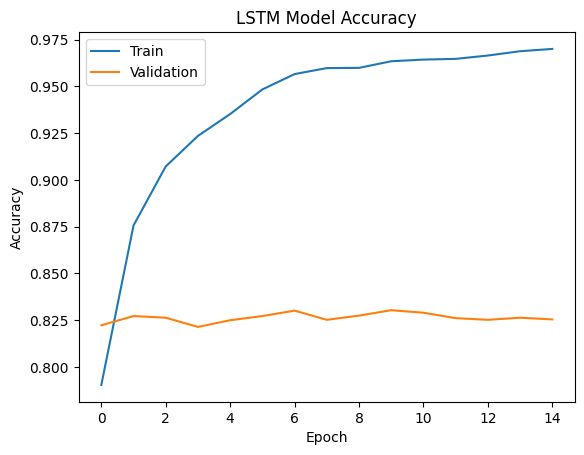

In [51]:
# Plot epochs vs accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

thresholds = np.arange(0.0, 1.0, 0.01)
acc_scores = []

for threshold in thresholds:
    y_pred = (model.predict(X_test_lstm) > threshold).astype(int)
    a_score = accuracy_score(y_test, y_pred)
    acc_scores.append(a_score)

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
140/140 ━━━━━━━━

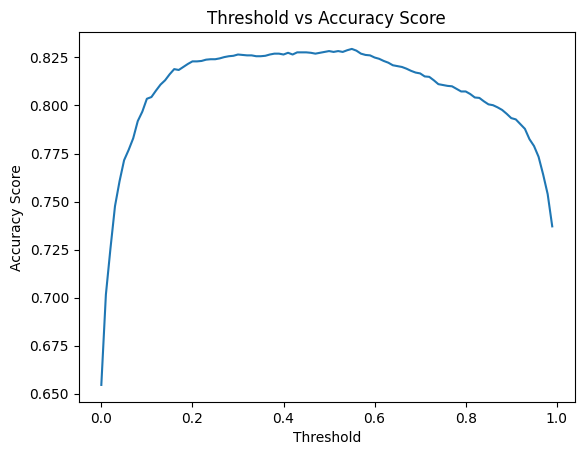

Best Threshold based on accuracy: 0.55
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1545
           1       0.86      0.88      0.87      2928

    accuracy                           0.83      4473
   macro avg       0.81      0.80      0.81      4473
weighted avg       0.83      0.83      0.83      4473


Confusion Matrix:
[[1121  424]
 [ 339 2589]]

Accuracy: 0.8294209702660407


In [ ]:
plt.plot(thresholds, acc_scores)
plt.title('Threshold vs Accuracy Score')
plt.xlabel('Threshold')
plt.ylabel('Accuracy Score')
plt.show()

best_threshold = thresholds[np.argmax(acc_scores)]
print(f"Best Threshold based on accuracy: {best_threshold}")
y_pred = (model.predict(X_test_lstm) > best_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy}")

In [ ]:
# Pickle lstm model
import pickle

with open('lstm_model.pkl', 'wb') as file:
    pickle.dump(model, file)

### BERT

In [28]:
scorp = pd.read_pickle('Stemmed.pkl')

In [29]:
le = LabelEncoder()
scorp['label'] = le.fit_transform(scorp['label'])

In [30]:
# Tokenizing
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_text(texts, labels, tokenizer, max_length=128):
  encoding = tokenizer(
      texts,
      padding=True,
      truncation=True,
      max_length=max_length,
      return_tensors='pt'
  )

  return encoding['input_ids'], encoding['attention_mask'], labels


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [31]:
# Splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scorp['processed_text'], scorp['label'], test_size=0.2, random_state=101)

In [32]:
# Model Setup
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
     num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Preprocess data
input_ids, attention_masks, y_train = preprocess_text(X_train.tolist(), y_train.tolist(), tokenizer)
input_ids_val, attention_masks_val, y_test = preprocess_text(X_test.tolist(), y_test.tolist(), tokenizer)

In [34]:
# Create DataLoader
train_data = TensorDataset(input_ids, attention_masks, torch.tensor(y_train))
val_data = TensorDataset(input_ids_val, attention_masks_val, torch.tensor(y_test))

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In [35]:
from transformers import AdamW

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [36]:
from transformers import get_scheduler

epochs = 10


# Scheduler for learning rate decay
num_training_steps = len(train_loader) * epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch + 1} completed.")


Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.


In [37]:
# 10 Epochs

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
print("Classification Report:")
print(classification_report(true_labels, predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predictions))
# Accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"\nAccuracy: {accuracy}")


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1545
           1       0.87      0.88      0.88      2928

    accuracy                           0.84      4473
   macro avg       0.82      0.82      0.82      4473
weighted avg       0.84      0.84      0.84      4473


Confusion Matrix:
[[1159  386]
 [ 337 2591]]

Accuracy: 0.8383635144198525


### Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=200,
                            max_depth=None,
                            min_samples_leaf=2,
                            min_samples_split=5,
                            random_state=101)
rf.fit(X_train_res, y_train_res)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Classification Report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7551978537894031
              precision    recall  f1-score   support

           0       0.72      0.47      0.57      1545
           1       0.76      0.90      0.83      2928

    accuracy                           0.76      4473
   macro avg       0.74      0.69      0.70      4473
weighted avg       0.75      0.76      0.74      4473

[[ 729  816]
 [ 279 2649]]


In [24]:
# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.47      0.57      1545
           1       0.76      0.90      0.83      2928

    accuracy                           0.76      4473
   macro avg       0.74      0.69      0.70      4473
weighted avg       0.75      0.76      0.74      4473


Confusion Matrix:
[[ 729  816]
 [ 279 2649]]


In [20]:
# Pickle random forest
import pickle

with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf, file)

### Naive Bayes

In [13]:
stm = pd.read_pickle('Stemmed.pkl')

In [14]:
# Label encode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
stm['label'] = le.fit_transform(stm['label'])

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Converting to DTM
cv = CountVectorizer(stop_words='english')

sdtm = cv.fit_transform(stm['processed_text'])

In [16]:
X = sdtm
y = stm['label']

In [17]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [18]:
# resample with smote
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=101)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [19]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train, y_train)

0.7364185110663984

[[ 787  758]
 [ 421 2507]]

              precision    recall  f1-score   support

           0       0.65      0.51      0.57      1545
           1       0.77      0.86      0.81      2928

    accuracy                           0.74      4473
   macro avg       0.71      0.68      0.69      4473
weighted avg       0.73      0.74      0.73      4473



In [27]:
print(nb.score(X_test, y_test))
print()
print("Confusion Matrix:")
print(confusion_matrix(y_test, nb.predict(X_test)))
print()
print("Classification Report:")
print(classification_report(y_test, nb.predict(X_test)))

0.7364185110663984

Confusion Matrix:
[[ 787  758]
 [ 421 2507]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.51      0.57      1545
           1       0.77      0.86      0.81      2928

    accuracy                           0.74      4473
   macro avg       0.71      0.68      0.69      4473
weighted avg       0.73      0.74      0.73      4473



In [21]:
# Pickle nb
import pickle

with open('nb_model.pkl', 'wb') as file:
    pickle.dump(nb, file)